In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_cv
import os
# FIXME: Silahkan ubah kalau mau liat error dan warning (0: semuanya, 1: info hilang, 2: info warning hilang, 3: semua hilang)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf
import re

2024-06-11 20:16:20.640618: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 20:16:22.097776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Pipeline

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# dataset_location = './Food ingredient recognition.v4i.tfrecord'
# dataset_location = './drive/MyDrive/Food ingredient recognition.v4i.tfrecord' # Google Colab
# dataset_location = "/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/Food ingredient recognition.v4i.tfrecord" # Punya Andi (yang lama)
# dataset_location = "/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/Vegetables.v1i.tfrecord" # Punya Andi (yang baru)   
dataset_location = "/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/ingredients-set 1-.v1i.tfrecord" # Punya Andi (yang baru 2)
# tfrecord_name = "food-ingredient.tfrecord" # yang lama
tfrecord_name = "bawang.tfrecord" # Yang baru
# label_map_name = "food-ingredient_label_map.pbtxt" # yang lama
label_map_name = "bawang_label_map.pbtxt" # yang baru
load_from_checkpoint = False
print(os.path.exists(dataset_location))

True


In [4]:
dataset_train = tf.data.TFRecordDataset(dataset_location + f"/train/{tfrecord_name}")
dataset_validation = tf.data.TFRecordDataset(dataset_location + f"/valid/{tfrecord_name}")
if (os.path.exists(dataset_location + f"/test/{tfrecord_name}")):
    dataset_test = tf.data.TFRecordDataset(dataset_location + f"/test/{tfrecord_name}")
else :
    dataset_test = tf.data.TFRecordDataset(dataset_location + f"/valid/{tfrecord_name}")

2024-06-11 20:16:28.398902: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-11 20:16:29.536221: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-11 20:16:29.536298: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-11 20:16:29.538479: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-11 20:16:29.538545: I external/local_xla/xla/stream_executor

In [5]:
feature_description = {
    'image/object/bbox/ymin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax' : tf.io.VarLenFeature(tf.float32),
    'image/object/class/text' : tf.io.VarLenFeature(tf.string),
    'image/object/class/label' : tf.io.VarLenFeature(tf.int64),
    'image/encoded' : tf.io.FixedLenFeature([], tf.string),
    'image/format' : tf.io.FixedLenFeature([], tf.string),
    'image/filename' : tf.io.FixedLenFeature([], tf.string),
    'image/height' : tf.io.FixedLenFeature([], tf.int64),
    'image/width' : tf.io.FixedLenFeature([], tf.int64)
}
def _parse_function(example_proto):
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    bounding_box = ['image/object/bbox/ymin', 'image/object/bbox/xmin', 'image/object/bbox/ymax', 'image/object/bbox/xmax']
    for key in ['image/object/bbox/ymin', 'image/object/bbox/xmin', 'image/object/bbox/ymax', 'image/object/bbox/xmax', 'image/object/class/text', 'image/object/class/label']:
        parsed_example[key] = tf.sparse.to_dense(parsed_example[key])
        if (key in bounding_box and "x" in key):
            parsed_example[key] = parsed_example[key] * tf.cast(parsed_example['image/width'], tf.float32)
        elif (key in bounding_box):
            parsed_example[key] = parsed_example[key] * tf.cast(parsed_example['image/height'], tf.float32)
    return parsed_example

In [6]:
def parse_pbtxt(pbtxt_content):
    # Regular expressions for extracting id, name, and display_name
    id_pattern = re.compile(r'id:\s*(\d+)')
    name_pattern = re.compile(r'name:\s*"([^"]+)"')
    display_name_pattern = re.compile(r'display_name:\s*"([^"]+)"')

    label_map = []

    items = pbtxt_content.split('item {')
    for item in items:
        if not item.strip():
            continue
        
        id_match = id_pattern.search(item)
        name_match = name_pattern.search(item)
        display_name_match = display_name_pattern.search(item)
        
        if id_match and name_match:
            item_dict = {
                'id': int(id_match.group(1)),
                'name': name_match.group(1),
                'display_name': display_name_match.group(1) if display_name_match else name_match.group(1)
            }
            label_map.append(item_dict)

    return label_map

def parse_pbtxt_file(file_path):
    with open(file_path, 'r') as file:
        pbtxt_content = file.read()
    return parse_pbtxt(pbtxt_content)


In [7]:
from keras_cv import bounding_box
from keras_cv import visualization

label_map = parse_pbtxt_file(dataset_location + f"/train/{label_map_name}")

class_mapping = {item['id']: item['display_name'] for item in label_map}

def preprocess_dataset(parsed_dataset):
    image = tf.image.decode_jpeg(parsed_dataset['image/encoded'])
    label = parsed_dataset['image/object/class/label']
    bounding_box = tf.stack([
        parsed_dataset['image/object/bbox/xmin'],
        parsed_dataset['image/object/bbox/ymin'],
        parsed_dataset['image/object/bbox/xmax'],
        parsed_dataset['image/object/bbox/ymax']
    ], axis=-1)
    image = tf.cast(image, tf.float32)
    return {
        'images': image,
        'bounding_boxes' : {
            'boxes': tf.cast(bounding_box, tf.float32),
            'classes': tf.cast(label, tf.int32)
        }
    }

def visualize_data(image, bounding_boxes):
    image = np.array(image)
    inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
    )
    image = inference_resizing([image])
    visualization.plot_bounding_box_gallery(
        image,
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xywh',
        y_pred=bounding_boxes
    )

augmenter = tf.keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.RandomHue(factor=0.015,
                                         value_range=(0., 255.)),
        keras_cv.layers.RandomBrightness(factor=0.25,
                                        value_range=(0., 255.)),
        keras_cv.layers.JitteredResize(
            # target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

validation_augmenter = tf.keras.Sequential(
    layers=[
        keras_cv.layers.JitteredResize(
            # target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        )
    ]
)

2024-06-11 20:16:45.057793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


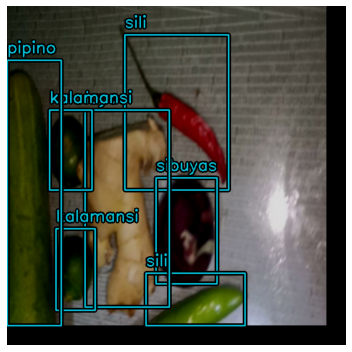

In [8]:
from keras_cv import bounding_box

BATCH_SIZE = 16

train_data_initial = dataset_train.map(_parse_function).map(preprocess_dataset).shuffle(buffer_size=BATCH_SIZE * 4).ragged_batch(BATCH_SIZE, drop_remainder=True)
train_data_resized = train_data_initial.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(inputs["bounding_boxes"], max_boxes=32)

train_data = train_data_resized.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

for result in train_data.take(1):
    visualization.plot_bounding_box_gallery(
        result[0],
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xyxy',
        y_true=result[1],
        class_mapping=class_mapping
    )


In [9]:
validation_data_initial = dataset_validation.map(_parse_function).map(preprocess_dataset).ragged_batch(BATCH_SIZE, drop_remainder=True)
validation_data_resized = validation_data_initial.map(validation_augmenter, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data_resized.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

In [10]:
test_data_initial = dataset_test.map(_parse_function).map(preprocess_dataset).ragged_batch(BATCH_SIZE, drop_remainder=True)
test_data_resized = test_data_initial.map(validation_augmenter, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data_resized.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [11]:
NUM_CLASSES = len(class_mapping)

In [12]:
if load_from_checkpoint:
    model = tf.keras.models.load_model("/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/checkpoint.model.keras")
else:
    # Pretrained backbone
    backbone = keras_cv.models.YOLOV8Backbone.from_preset(
        "yolo_v8_s_backbone_coco",
        include_rescaling = True,
    )

    prediction_decoder = keras_cv.layers.NonMaxSuppression(
        from_logits=True,
        # Makin tinggi perlu confidence makin tinggi
        confidence_threshold=0.75,
        # Makin rendah maka makin banyak bounding box yang diambil. Semakin tinggi semakin mepet
        iou_threshold=0.5,
        bounding_box_format="xyxy",
    )

    model = keras_cv.models.YOLOV8Detector(
        num_classes=NUM_CLASSES,
        bounding_box_format="xyxy",
        backbone=backbone,
        # fpn_depth=1,
        prediction_decoder=prediction_decoder,
    )


    model = keras_cv.models.YOLOV8Detector.from_preset(
        "yolo_v8_s_backbone_coco", 
        bounding_box_format="xyxy",
        num_classes=NUM_CLASSES,
        prediction_decoder=prediction_decoder,
        # include_rescaling = True,
    )



I0000 00:00:1718111811.440450 1163742 service.cc:145] XLA service 0x7f0ca04161a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718111811.440516 1163742 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-11 20:16:51.572968: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-11 20:16:52.030890: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1718111828.441213 1163742 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
{'boxes': array([[[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       ...,

       [[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1

2024-06-11 20:17:11.322903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


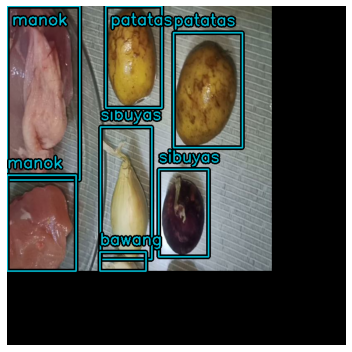

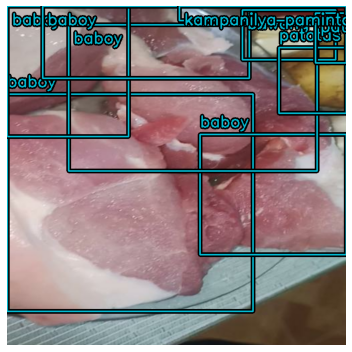

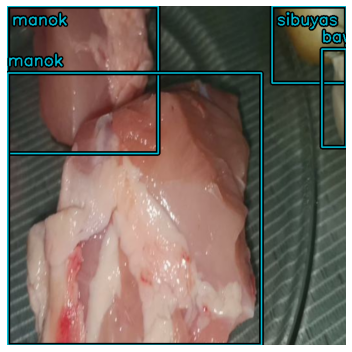

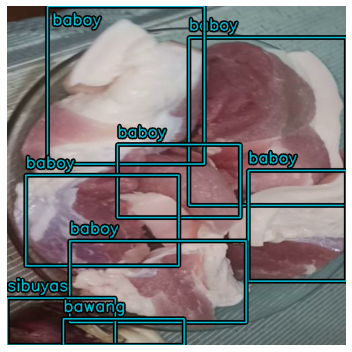

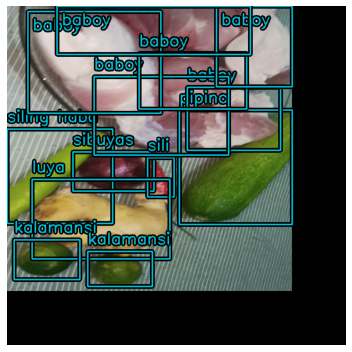

In [13]:
for result in test_data.take(5):
    y_pred = model.predict(result[0])
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        result[0],
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xyxy',
        y_pred=y_pred,
        y_true=result[1],
        class_mapping=class_mapping
    )

In [14]:
freeze = 133
# Freeze to up to 133 layers
# for i, layer in enumerate(model.layers):
#     if i < freeze:
#         layer.trainable = False


In [15]:
class EvaluateCOCOMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [16]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    global_clipnorm = 10.0
)



model.compile(
    optimizer=optimizer, 
    # classification_loss="binary_crossentropy", 
    # classification_loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    classification_loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    # classification_loss=keras_cv.losses.FocalLoss(),
    box_loss=keras_cv.losses.CIoULoss("xyxy", eps=1e-07),
    # box_loss="ciou",
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=10,
                              min_lr=1e-6,
                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoint.model.keras",
    save_best_only=True,
    monitor="val_loss",
    verbose=1,
)

model.fit(train_data, 
          epochs=350, 
          validation_data=validation_data,
          callbacks=[
              EvaluateCOCOMetricsCallback(validation_data, "model.keras"), 
              early_stopping, 
              reduce_lr,
              model_checkpoint,
              ])

Epoch 1/350
     58/Unknown 109s 380ms/step - loss: 3.6173e-05

2024-06-11 20:19:00.611683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:19:00.612734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-06-11 20:19:08.967525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:19:08.967587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is abortin


Epoch 1: val_loss improved from inf to 0.00004, saving model to checkpoint.model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 129s 739ms/step - loss: 3.6164e-05 - val_loss: 3.5474e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - loss: 3.6151e-05

2024-06-11 20:19:59.964843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:19:59.965321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:20:04.287154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:20:04.287295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 2: val_loss did not improve from 0.00004
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 700ms/step - loss: 3.6150e-05 - val_loss: 3.7820e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/350


2024-06-11 20:20:10.285572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - loss: 3.5510e-05

2024-06-11 20:20:50.157889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:20:50.158178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:20:55.633213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:20:55.638872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 20:20:55.638941: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 20:20:55.639177: I tensorflow/core/framework/local_ren


Epoch 3: val_loss did not improve from 0.00004
58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 775ms/step - loss: 3.5516e-05 - val_loss: 3.6190e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 3.6064e-05

2024-06-11 20:21:40.415843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:21:40.416725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:21:44.748367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:21:44.748430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 20:21:44.748485: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 20:21:44.748497: I tensorflow/core/framework/local_ren


Epoch 4: val_loss did not improve from 0.00004
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 676ms/step - loss: 3.6060e-05 - val_loss: 3.6245e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - loss: 3.5676e-05

2024-06-11 20:22:29.851443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:22:29.851936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:22:33.782354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:22:33.782570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 5: val_loss did not improve from 0.00004
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 684ms/step - loss: 3.5672e-05 - val_loss: 3.5493e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/350


2024-06-11 20:22:40.508656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - loss: 3.5021e-05

2024-06-11 20:23:18.251999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:23:18.253263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:23:23.202647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:23:23.202700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 20:23:23.202752: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 20:23:23.202764: I tensorflow/core/framework/local_ren


Epoch 6: val_loss improved from 0.00004 to 0.00003, saving model to checkpoint.model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 745ms/step - loss: 3.5019e-05 - val_loss: 3.4955e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - loss: 3.4274e-05

2024-06-11 20:24:10.091534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:24:10.092250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:24:14.405319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:24:14.405565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:24:20.030257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 7: val_loss improved from 0.00003 to 0.00003, saving model to checkpoint.model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 710ms/step - loss: 3.4279e-05 - val_loss: 3.4590e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 0.0010
Epoch 8/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 3.4129e-05

2024-06-11 20:24:58.897754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:24:58.898879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:25:03.197668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:25:03.197867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:25:09.183259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 8: val_loss improved from 0.00003 to 0.00003, saving model to checkpoint.model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 697ms/step - loss: 3.4128e-05 - val_loss: 3.3741e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 3.3508e-05

2024-06-11 20:25:48.649595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:25:48.651074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:25:52.934536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:25:52.934729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:25:58.889483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 9: val_loss improved from 0.00003 to 0.00003, saving model to checkpoint.model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 729ms/step - loss: 3.3504e-05 - val_loss: 3.2201e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 0.0010
Epoch 10/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 3.2672e-05

2024-06-11 20:26:38.233407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:26:38.235454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:26:42.144194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:26:42.144341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:26:47.876562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 10: val_loss improved from 0.00003 to 0.00003, saving model to checkpoint.model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 680ms/step - loss: 3.2670e-05 - val_loss: 3.2031e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 0.0010
Epoch 11/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 3.1900e-05

2024-06-11 20:27:26.908345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:27:26.909625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:27:30.796614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:27:30.796665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 20:27:30.796705: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 20:27:30.796717: I tensorflow/core/framework/local_ren


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 11: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 667ms/step - loss: 3.1895e-05 - val_loss: 3.2072e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 0.0010
Epoch 12/350


2024-06-11 20:27:36.776283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - loss: 3.1293e-05

2024-06-11 20:28:16.676579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:28:16.677330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:28:20.844771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:28:20.844896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 20:28:20.844915: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 20:28:20.844926: I tensorflow/core/framework/local_ren


Epoch 12: val_loss improved from 0.00003 to 0.00003, saving model to checkpoint.model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 709ms/step - loss: 3.1295e-05 - val_loss: 3.0422e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 13/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 3.1777e-05

2024-06-11 20:29:05.731543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:29:05.731969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:29:09.893873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:29:09.894033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 13: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 663ms/step - loss: 3.1769e-05 - val_loss: 3.1332e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 14/350


2024-06-11 20:29:15.728748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 3.0554e-05

2024-06-11 20:29:54.065339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:29:54.066089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:29:57.952950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:29:57.953002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 20:29:57.953012: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 20:29:57.953019: I tensorflow/core/framework/local_ren


Epoch 14: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 689ms/step - loss: 3.0556e-05 - val_loss: 3.1061e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 15/350


2024-06-11 20:30:03.627007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 3.1070e-05

2024-06-11 20:30:42.210287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:30:42.210650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:30:46.334255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:30:46.334430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:30:52.311444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 15: val_loss improved from 0.00003 to 0.00003, saving model to checkpoint.model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 702ms/step - loss: 3.1064e-05 - val_loss: 3.0191e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 16/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - loss: 3.0704e-05

2024-06-11 20:31:32.254747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:31:32.255753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:31:36.714506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:31:36.714645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:31:42.953674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 16: val_loss improved from 0.00003 to 0.00003, saving model to checkpoint.model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 723ms/step - loss: 3.0701e-05 - val_loss: 2.9549e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 17/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 3.0046e-05

2024-06-11 20:32:24.242891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:32:24.243434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:32:28.417816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:32:28.417999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 17: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 707ms/step - loss: 3.0043e-05 - val_loss: 2.9588e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 18/350


2024-06-11 20:32:34.367312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - loss: 2.9391e-05

2024-06-11 20:33:13.913076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:33:13.914458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:33:18.898957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:33:18.899157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 18: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 703ms/step - loss: 2.9388e-05 - val_loss: 3.0032e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 19/350


2024-06-11 20:33:25.166652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - loss: 3.0459e-05

2024-06-11 20:34:05.347402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:34:05.348471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:34:09.577823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:34:09.578007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:34:15.624248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 19: val_loss improved from 0.00003 to 0.00003, saving model to checkpoint.model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 720ms/step - loss: 3.0450e-05 - val_loss: 2.9179e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 20/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - loss: 2.8943e-05

2024-06-11 20:34:56.984411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:34:56.984803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:35:01.283302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:35:01.283495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 20: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 699ms/step - loss: 2.8949e-05 - val_loss: 2.9738e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 21/350


2024-06-11 20:35:07.402062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - loss: 2.9312e-05

2024-06-11 20:35:47.954953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:35:47.955899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:35:52.000443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:35:52.000594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:35:57.853472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 21: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 21: val_loss improved from 0.00003 to 0.00003, saving model to checkpoint.model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 740ms/step - loss: 2.9310e-05 - val_loss: 2.9099e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 22/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 2.8907e-05

2024-06-11 20:36:37.095087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:36:37.095593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:36:40.981735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:36:40.981915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:36:47.078191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 22: val_loss improved from 0.00003 to 0.00003, saving model to checkpoint.model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 683ms/step - loss: 2.8915e-05 - val_loss: 2.8357e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 23/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 2.8833e-05

2024-06-11 20:37:27.153133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:37:27.154418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:37:31.067226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:37:31.067286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 20:37:31.067300: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 20:37:31.067306: I tensorflow/core/framework/local_ren


Epoch 23: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 662ms/step - loss: 2.8834e-05 - val_loss: 2.9030e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 24/350


2024-06-11 20:37:36.762061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 2.8924e-05

2024-06-11 20:38:15.873437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:38:15.874351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:38:19.954511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:38:19.954647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 24: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 677ms/step - loss: 2.8927e-05 - val_loss: 2.8922e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 25/350


2024-06-11 20:38:25.942359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - loss: 2.8915e-05

2024-06-11 20:39:04.626586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:39:04.627720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:39:08.534133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:39:08.534311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:39:14.673933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 25: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 58s 835ms/step - loss: 2.8921e-05 - val_loss: 2.8831e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 26/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 2.8914e-05

2024-06-11 20:40:01.822356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:40:01.823053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:40:06.053697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:40:06.053885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 26: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 671ms/step - loss: 2.8915e-05 - val_loss: 2.9963e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 27/350


2024-06-11 20:40:12.165633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - loss: 2.9629e-05

2024-06-11 20:40:51.491193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:40:51.491991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:40:55.367483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:40:55.367575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 20:40:55.367598: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 20:40:55.367605: I tensorflow/core/framework/local_ren


Epoch 27: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 696ms/step - loss: 2.9623e-05 - val_loss: 2.9012e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 28/350


2024-06-11 20:41:01.284911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - loss: 2.8836e-05

2024-06-11 20:41:39.926174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:41:39.927126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:41:43.884319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:41:43.884369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 20:41:43.884380: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 20:41:43.884387: I tensorflow/core/framework/local_ren


Epoch 28: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 664ms/step - loss: 2.8841e-05 - val_loss: 2.8545e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 29/350


2024-06-11 20:41:49.517625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - loss: 2.8871e-05

2024-06-11 20:42:29.761704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:42:29.762911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:42:34.076983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:42:34.077072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 29: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 716ms/step - loss: 2.8868e-05 - val_loss: 2.8429e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 30/350


2024-06-11 20:42:39.658568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 2.8389e-05

2024-06-11 20:43:18.236445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:43:18.236870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:43:22.183627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:43:22.183813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 30: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 661ms/step - loss: 2.8396e-05 - val_loss: 2.8957e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 31/350


2024-06-11 20:43:27.913150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - loss: 2.9192e-05

2024-06-11 20:44:07.294887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:44:07.295942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:44:11.590082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:44:11.590308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 31: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 31: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 716ms/step - loss: 2.9189e-05 - val_loss: 2.9085e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 32/350


2024-06-11 20:44:18.265250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - loss: 2.8551e-05

2024-06-11 20:44:58.571971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:44:58.572942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:45:02.770907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:45:02.771183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 32: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 705ms/step - loss: 2.8557e-05 - val_loss: 2.9349e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 33/350


2024-06-11 20:45:09.198839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - loss: 2.9314e-05

2024-06-11 20:45:49.493634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:45:49.494581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:45:53.751574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:45:53.751700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:45:59.670061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 33: val_loss improved from 0.00003 to 0.00003, saving model to checkpoint.model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 747ms/step - loss: 2.9311e-05 - val_loss: 2.7980e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 34/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - loss: 2.9167e-05

2024-06-11 20:46:42.106057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:46:42.107157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:46:46.358435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:46:46.358486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 20:46:46.358529: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 20:46:46.358537: I tensorflow/core/framework/local_ren


Epoch 34: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 717ms/step - loss: 2.9165e-05 - val_loss: 2.8411e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 35/350


2024-06-11 20:46:52.417460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - loss: 2.9070e-05

2024-06-11 20:47:32.280833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:47:32.281226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:47:36.240500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:47:36.240687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 35: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 676ms/step - loss: 2.9071e-05 - val_loss: 2.8498e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 36/350


2024-06-11 20:47:41.921904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 2.8720e-05

2024-06-11 20:48:20.346544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:48:20.348343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:48:24.724184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:48:24.724380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 36: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 668ms/step - loss: 2.8722e-05 - val_loss: 2.8566e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 37/350


2024-06-11 20:48:30.825306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - loss: 2.8376e-05

2024-06-11 20:49:10.008966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:49:10.010029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:49:14.332448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:49:14.332606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 37: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 720ms/step - loss: 2.8377e-05 - val_loss: 2.8246e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 38/350


2024-06-11 20:49:20.326487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - loss: 2.8815e-05

2024-06-11 20:50:00.802993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:50:00.803790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:50:05.011876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:50:05.011974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 20:50:05.011988: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 20:50:05.011996: I tensorflow/core/framework/local_ren


Epoch 38: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 685ms/step - loss: 2.8817e-05 - val_loss: 2.8527e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 39/350


2024-06-11 20:50:10.946127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 2.9323e-05

2024-06-11 20:50:48.756437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:50:48.757231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:50:52.697817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:50:52.697877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 20:50:52.697891: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 20:50:52.697898: I tensorflow/core/framework/local_ren


Epoch 39: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 656ms/step - loss: 2.9321e-05 - val_loss: 2.8739e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 40/350


2024-06-11 20:50:58.648687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - loss: 2.8314e-05

2024-06-11 20:51:37.181276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:51:37.182237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:51:41.373971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:51:41.374162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 40: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 695ms/step - loss: 2.8318e-05 - val_loss: 2.8622e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 41/350


2024-06-11 20:51:47.492813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 2.9058e-05

2024-06-11 20:52:26.415359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:52:26.416163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:52:30.614586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:52:30.614853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 41: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 41: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 719ms/step - loss: 2.9055e-05 - val_loss: 2.8380e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 42/350


2024-06-11 20:52:37.054418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - loss: 2.8624e-05

2024-06-11 20:53:17.569561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:53:17.570574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:53:21.846873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:53:21.847059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 42: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 693ms/step - loss: 2.8626e-05 - val_loss: 2.8866e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 43/350


2024-06-11 20:53:27.913741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - loss: 2.8001e-05

2024-06-11 20:54:08.076588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:54:08.077794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:54:12.270498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:54:12.270585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 43: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 686ms/step - loss: 2.8012e-05 - val_loss: 2.8316e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 44/350


2024-06-11 20:54:17.932225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - loss: 2.8532e-05

2024-06-11 20:54:57.569570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:54:57.570002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:55:01.520072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:55:01.520133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 20:55:01.520170: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 20:55:01.520179: I tensorflow/core/framework/local_ren


Epoch 44: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 704ms/step - loss: 2.8534e-05 - val_loss: 2.8782e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 45/350


2024-06-11 20:55:07.139243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - loss: 2.9101e-05

2024-06-11 20:55:45.198737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:55:45.199768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:55:49.271394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:55:49.271467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 45: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 647ms/step - loss: 2.9096e-05 - val_loss: 2.8722e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 46/350


2024-06-11 20:55:55.083832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - loss: 2.8045e-05

2024-06-11 20:56:32.891530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:56:32.892505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:56:37.023352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:56:37.023550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 46: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 47s 635ms/step - loss: 2.8053e-05 - val_loss: 2.8215e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 47/350


2024-06-11 20:56:42.536521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - loss: 2.8248e-05

2024-06-11 20:57:21.533661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:57:21.533897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:57:26.169196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:57:26.169279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 20:57:26.169302: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 20:57:26.169318: I tensorflow/core/framework/local_ren


Epoch 47: val_loss improved from 0.00003 to 0.00003, saving model to checkpoint.model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 748ms/step - loss: 2.8252e-05 - val_loss: 2.7948e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 48/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - loss: 2.8712e-05

2024-06-11 20:58:13.933009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:58:13.933527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:58:18.120666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:58:18.120862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 48: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 687ms/step - loss: 2.8717e-05 - val_loss: 2.8402e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 49/350


2024-06-11 20:58:24.280446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 2.8623e-05

2024-06-11 20:59:02.656166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:59:02.656892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:59:07.273232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:59:07.273418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 49: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 675ms/step - loss: 2.8628e-05 - val_loss: 2.8780e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 50/350


2024-06-11 20:59:13.155282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 2.9115e-05

2024-06-11 20:59:51.963878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:59:51.964892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 20:59:56.000049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 20:59:56.000180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 50: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 659ms/step - loss: 2.9118e-05 - val_loss: 2.9223e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 51/350


2024-06-11 21:00:01.899356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 2.9110e-05

2024-06-11 21:00:40.790076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:00:40.791112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 21:00:44.962837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:00:44.963024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 51: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 695ms/step - loss: 2.9108e-05 - val_loss: 2.8984e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 52/350


2024-06-11 21:00:50.645741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 2.8686e-05

2024-06-11 21:01:29.833101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:01:29.834051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 21:01:33.807352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:01:33.807580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 52: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 661ms/step - loss: 2.8690e-05 - val_loss: 2.8530e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 53/350


2024-06-11 21:01:39.372431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - loss: 2.9039e-05

2024-06-11 21:02:17.057678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:02:17.058144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 21:02:21.047400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:02:21.047467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 53: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 47s 670ms/step - loss: 2.9037e-05 - val_loss: 2.8721e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 54/350


2024-06-11 21:02:26.635166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - loss: 2.8951e-05

2024-06-11 21:03:05.488056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:03:05.489035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 21:03:09.572268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:03:09.572412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 54: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 674ms/step - loss: 2.8953e-05 - val_loss: 2.8113e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 55/350


2024-06-11 21:03:15.280171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 2.8481e-05

2024-06-11 21:03:53.962922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:03:53.964023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 21:03:58.204081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:03:58.204140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 21:03:58.204154: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 21:03:58.204162: I tensorflow/core/framework/local_ren


Epoch 55: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 658ms/step - loss: 2.8483e-05 - val_loss: 2.8762e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 56/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 2.8455e-05

2024-06-11 21:04:42.342951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:04:42.343457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 21:04:46.429290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:04:46.429355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 56: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 661ms/step - loss: 2.8458e-05 - val_loss: 2.8756e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 57/350


2024-06-11 21:04:52.103634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - loss: 2.8923e-05

2024-06-11 21:05:29.960757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:05:29.961419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 21:05:33.808112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:05:33.808213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 57: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 47s 672ms/step - loss: 2.8915e-05 - val_loss: 2.8495e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 58/350


2024-06-11 21:05:39.513423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 2.9106e-05

2024-06-11 21:06:18.496395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:06:18.497802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 21:06:22.778335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:06:22.778507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 58: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 675ms/step - loss: 2.9103e-05 - val_loss: 2.8414e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 59/350


2024-06-11 21:06:28.445840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - loss: 2.8911e-05

2024-06-11 21:07:07.402808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:07:07.403784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 21:07:11.905830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:07:11.906062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 59: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 727ms/step - loss: 2.8903e-05 - val_loss: 2.8037e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 60/350


2024-06-11 21:07:17.712719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - loss: 2.8563e-05

2024-06-11 21:07:56.119026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:07:56.120067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 21:08:00.214968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:08:00.215141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 60: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 688ms/step - loss: 2.8568e-05 - val_loss: 2.8043e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 61/350


2024-06-11 21:08:05.539439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - loss: 2.8420e-05

2024-06-11 21:08:44.531379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:08:44.532284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 21:08:48.514509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:08:48.514570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-11 21:08:48.514582: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5988110300982278201
2024-06-11 21:08:48.514589: I tensorflow/core/framework/local_ren


Epoch 61: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 680ms/step - loss: 2.8427e-05 - val_loss: 2.8918e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 62/350


2024-06-11 21:08:54.363870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 2.8490e-05

2024-06-11 21:09:32.531942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:09:32.532789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-11 21:09:36.543331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:09:36.543442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 62: val_loss did not improve from 0.00003
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 651ms/step - loss: 2.8498e-05 - val_loss: 2.9037e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - learning_rate: 1.0000e-06


2024-06-11 21:09:42.002101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
model.evaluate(test_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 2.9126e-05


2024-06-11 21:09:45.121199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:09:45.121257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2.964466875710059e-05

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
{'boxes': array([[[295.0117  ,  45.576477, 510.8202  , 340.4729  ],
        [145.28928 , -27.611053, 349.70758 , 256.65515 ],
        [197.68654 , 297.03256 , 334.0242  , 499.90637 ],
        ...,
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ]],

       [[137.25659 , 198.02698 , 368.1403  , 423.40683 ],
        [260.64072 ,  19.185692, 498.8781  , 240.55486 ],
        [341.549   , 223.47517 , 578.06903 , 447.89404 ],
        ...,
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ]],

       [[ 26.587486, 119.28063 , 192.29764 , 343.83264 ],
        [213.37991 , 174.34795 , 517.0066  , 506.53964 ],
        [184.74493 ,  23.056282, 414.77585 , 248.54721 ],
        ...,
        [ -1.      ,  -1.      ,  -1.    

2024-06-11 21:15:08.903059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


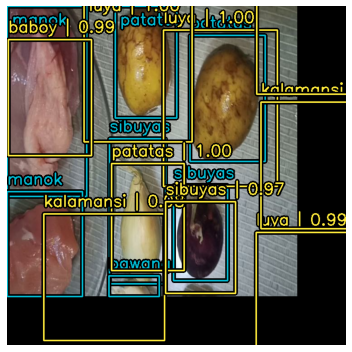

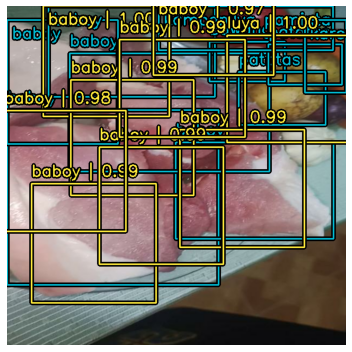

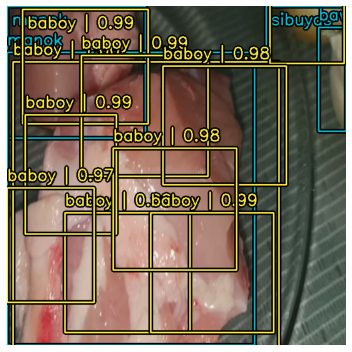

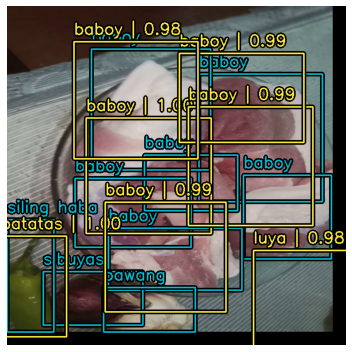

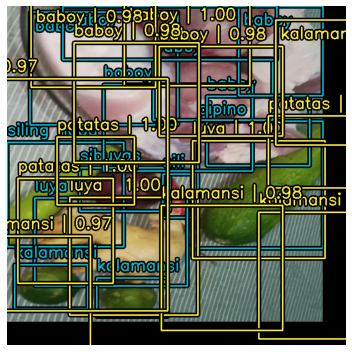

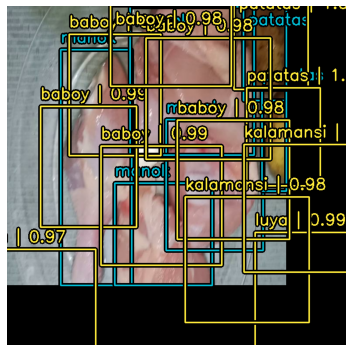

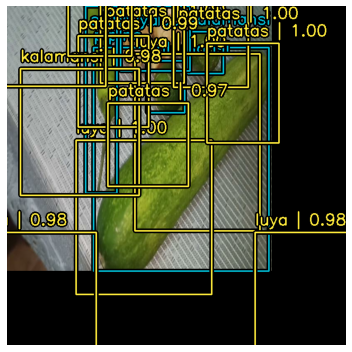

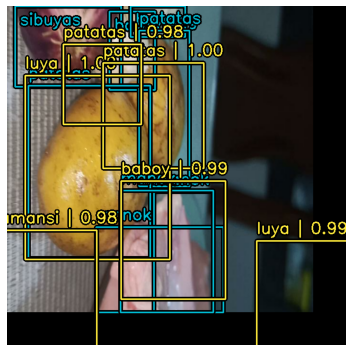

In [30]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    from_logits=False,
    confidence_threshold=0.97,
    iou_threshold=0.1,
    bounding_box_format="xyxy",
)
for result in test_data.take(10):
    y_pred = model.predict(result[0])
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        result[0],
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xyxy',
        y_pred=y_pred,
        y_true=result[1],
        class_mapping=class_mapping
    )

In [31]:
model.save("good_enough_model.keras")

In [32]:
model.export("/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model")

INFO:tensorflow:Assets written to: /mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model/assets


INFO:tensorflow:Assets written to: /mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model/assets


Saved artifact at '/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor_433')
Output Type:
  Dict[['boxes', TensorSpec(shape=(None, None, 64), dtype=tf.float32, name=None)], ['classes', TensorSpec(shape=(None, None, 14), dtype=tf.float32, name=None)]]
Captures:
  139693344842048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693344838000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693344845744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693344843104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693344843984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693344849264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693345063680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693345065616: TensorSpec(shape=(), dtype=tf.r

In [20]:
loaded_model = tf.keras.models.load_model("/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
{'boxes': array([[[154.25543, 351.98767, 347.41006, 493.04004],
        [154.70822, 342.34073, 342.43887, 484.20654],
        [150.49551, 331.78598, 335.85318, 474.22614],
        ...,
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ]],

       [[ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        ...,
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ]],

       [[ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        ...,
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1. 

2024-06-11 21:10:38.470819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


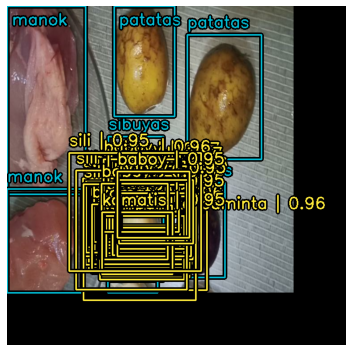

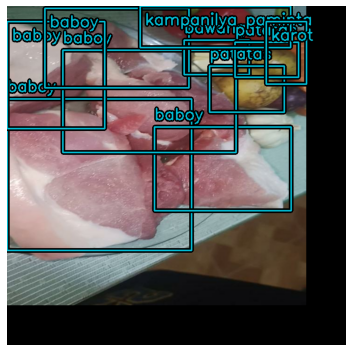

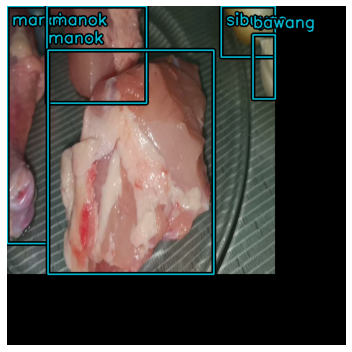

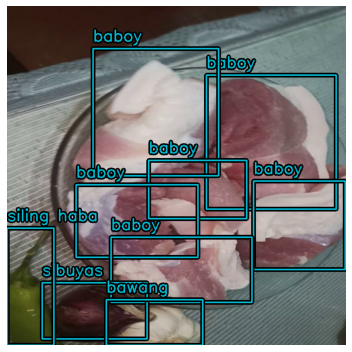

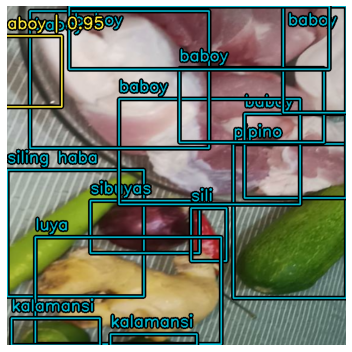

In [21]:
loaded_model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    from_logits=False,
    confidence_threshold=0.95,
    iou_threshold=0.9,
    bounding_box_format="xyxy",
)
for result in test_data.take(5):
    y_pred = loaded_model.predict(result[0])
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        result[0],
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xyxy',
        y_pred=y_pred,
        y_true=result[1],
        class_mapping=class_mapping
    )

In [22]:
loaded_model.compile(
    optimizer=optimizer, 
    # classification_loss="binary_crossentropy", 
    classification_loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    box_loss=keras_cv.losses.CIoULoss("xyxy", eps=1e-07)
)

In [23]:
loaded_model.evaluate(test_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 3.7261e-05


2024-06-11 21:10:44.420276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-11 21:10:44.420639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3.731003380380571e-05

In [24]:
loaded_model.export("/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model")

INFO:tensorflow:Assets written to: /mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model/assets


INFO:tensorflow:Assets written to: /mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model/assets


Saved artifact at '/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor_744')
Output Type:
  Dict[['boxes', TensorSpec(shape=(None, None, 64), dtype=tf.float32, name=None)], ['classes', TensorSpec(shape=(None, None, 14), dtype=tf.float32, name=None)]]
Captures:
  139691541034288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691541400560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691541402496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691541398272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691541400912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691541406016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691541405664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691541409888: TensorSpec(shape=(), dtype=tf.r

In [25]:
print(model.outputs)

[<KerasTensor shape=(None, None, 64), dtype=float32, sparse=False, name=keras_tensor_620>, <KerasTensor shape=(None, None, 14), dtype=float32, sparse=False, name=keras_tensor_621>]
